In [1]:
from simulation_env.environment_maincrops.environment_maincrops import CropRotationEnv
import numpy as np
import math
from models.utilities.ReplayBufferPrioritized import UniformReplayBuffer, Experience
import torch
import os 
# Set CUDA Setting: CUDA_LAUNCH_BLOCKING=1
# os.environ['CUDA_LAUNCH_BLOCKING'] = str(1)

c:\Users\Magnus\Documents\GitHub\cro_symbolic_mbpo


In [2]:
def create_full_replay_buffer(length = 10000, seq_len=10, seed = 42, batch_size = 128):
    env = CropRotationEnv(seed = seed, seq_len = seq_len)
    reward_factor = 5.0/(env.max_reward-env.min_reward)

    random_state = np.random.RandomState(seed)
    replay_buffer = UniformReplayBuffer(batch_size = batch_size,
                                        buffer_size = length,
                                        random_state=random_state)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Generate 5 random crop rotations without training (for enviornment testing)
    episodes = math.ceil(length/seq_len)+1
    buffer_length = 0
    while buffer_length < length:
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        done = False
        while not done:
            action = env.action_space.sample()
            next_state, _, reward, done, _ = env.step(action)
            if done:
                break
            if next_state is None:
                print("next_state is None")

            reward_tensor = torch.tensor([reward], device=device)*reward_factor
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            action_tensor = torch.tensor([action]).to(device)
            experience = Experience(state, action_tensor.view(1,1), reward_tensor.view(1,1), next_state_tensor, torch.tensor([done]).view(1,1))
            # print("Stats:", replay_buffer.buffer_size, replay_buffer.batch_size, replay_buffer._buffer_length, replay_buffer._current_idx)
            replay_buffer.add(experience)
            
            state = next_state_tensor
            buffer_length += 1
            


    return replay_buffer

replay_buffer = create_full_replay_buffer(length = 500, seq_len=10, seed=42, batch_size = 256)
for idx, entry in enumerate(replay_buffer._buffer):
    if entry is None:
        print(idx,entry)

replay_buffer_test = create_full_replay_buffer(length = 500, seq_len=10, seed=45, batch_size = 500)
for idx, entry in enumerate(replay_buffer_test._buffer):
    if entry is None:
        print(idx,entry)

In [3]:
import numpy as np
np.random.choice(np.arange(5),replace=True,size=10)

array([3, 2, 0, 4, 4, 0, 3, 1, 0, 0])

In [4]:
num_actions = 24
def format_samples_for_training(states, actions, rewards, next_states):
	delta_states = next_states - states
	# one-hot encode actions
	actions_ohe = torch.nn.functional.one_hot(actions, num_classes=num_actions).squeeze()
	inputs = torch.concatenate((actions_ohe, states), axis=-1).to(device).double()
	outputs = torch.concatenate((rewards, delta_states), axis=-1).to(device).double()

	return inputs, outputs


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

idxs, experiences = replay_buffer.sample()
states, actions, rewards, next_states, dones = (torch.stack(vs,0).squeeze(1).to(device) for vs in zip(*experiences))
inputs, outputs = format_samples_for_training(states, actions, rewards, next_states)


experiences = replay_buffer_test._buffer
states, actions, rewards, next_states, dones = (torch.stack(vs,0).squeeze(1).to(device) for vs in zip(*experiences))
test_inputs, test_outputs = format_samples_for_training(states, actions, rewards, next_states)
# # split inputs and outputs into train and test sets
# train_size = int(0.8 * len(inputs))
# test_size = len(inputs) - train_size
# inputs, test_inputs = torch.split(inputs, [train_size, test_size], dim=0)
# outputs, test_outputs = torch.split(outputs, [train_size, test_size], dim=0)

# print(inputs.shape)
# print(outputs.shape)




AttributeError: 'UniformReplayBuffer' object has no attribute 'sample'

: 

In [1294]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

In [1295]:
kl_weight = 0.01
def create_model_and_losses_and_optimizer(input_size, output_size, num_hidden_units, num_hidden_layers, stochastic_flag, activation = nn.ReLU(), lr = 0.001, weight_decay = 1e-7):
    if stochastic_flag == "stochastic_single":
        if num_hidden_layers == 0:
            model = nn.Sequential(
                bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=input_size, out_features=output_size),    
            )
        else:
            model = nn.Sequential(
                bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=input_size, out_features=num_hidden_units),
            )
            for i in range(num_hidden_layers-1):
                model.add_module('relu'+str(i), activation)
                model.add_module('hidden'+str(i), nn.Linear(in_features=num_hidden_units, out_features=num_hidden_units))
            model.add_module('relu'+str(num_hidden_layers-1), activation)
            model.add_module('final', nn.Linear(in_features=num_hidden_units, out_features=output_size))
        mse_loss = nn.MSELoss()
        kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
        kl_weight = 0.1
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad = False)
        return model.double().to(device), mse_loss, kl_loss, optimizer
            
    elif stochastic_flag == "none": 
        if num_hidden_layers == 0:
            model = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=output_size),    
            )
        else:
            model = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=num_hidden_units),
            )
            for i in range(num_hidden_layers-1):
                model.add_module('relu'+str(i), activation)
                model.add_module('hidden'+str(i), nn.Linear(in_features=num_hidden_units, out_features=num_hidden_units))
            model.add_module('relu'+str(num_hidden_layers-1), activation)
            model.add_module('final', nn.Linear(in_features=num_hidden_units, out_features=output_size))
        mse_loss = nn.MSELoss()
        kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad = False)
        return model.double().to(device), mse_loss, optimizer
    elif stochastic_flag == "stochastic_all":
        if num_hidden_layers == 0:
            model = nn.Sequential(
                bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=input_size, out_features=output_size),    
            )
        else:
            model = nn.Sequential(
                bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=input_size, out_features=num_hidden_units),
                # nn.Linear(in_features=input_size, out_features=num_hidden_units),
            )
            for i in range(num_hidden_layers-1):
                model.add_module('relu'+str(i), activation)
                model.add_module('hidden'+str(i), bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=num_hidden_units, out_features=num_hidden_units))
            model.add_module('relu'+str(num_hidden_layers-1), activation)
            model.add_module('final', bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=num_hidden_units, out_features=output_size))
        mse_loss = nn.MSELoss()
        kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
        kl_weight = 0.1
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad = False)
        return model.double().to(device), mse_loss, kl_loss, optimizer


In [1257]:
kl_weight_dict_static = {
    8: (0.001, 0.7780933993768321),
    9: (0.1, 0.7194993476150745),
    10: (0.05, 0.7242633294378622),
    11: (0.1, 0.9250756468612495),
    12: (0.1, 1.0078648159211328),
    13: (0.1, 1.0444126071011346),
    14: (0.1, 0.5989025656368236),
    15: (0.05, 1.020489052753217),
    16: (0.005, 1.1436469916944136),
    17: (0.01, 1.0049314846483366),
    18: (0.01, 0.971859775330824),
    19: (0.05, 0.8180994896759655),
    20: (0.001, 1.081486018433127),
    21: (0.1, 0.9461308654111512),
    22: (0.05, 0.9322478967845222),
    23: (0.01, 0.8344503502741057),
    24: (0.1, 0.7945537603884768),
    25: (0.05, 0.6923902497697012),
    26: (0.01, 0.9974622612272463),
    27: (0.05, 0.8926267019969254),
    28: (0.05, 1.0107791013701166),
    29: (0.1, 0.7013658537363352),
    30: (0.05, 0.9249607065668922),
    31: (0.1, 0.6773090142127736),
    32: (0.05, 0.893122425232194),
    33: (0.1, 0.5860964149150106),
    34: (0.05, 0.464493304734148),
    35: (0.0005, 0.992273518522048),
    36: (0.005, 1.0688761858940528),
    37: (0.005, 0.9416593768648827),
    38: (0.05, 0.8616778779484434),
    39: (0.05, 0.912609207616575),
    40: (0.0005, 0.942400731532975),
    41: (0.05, 0.9878489817210232),
    42: (0.1, 0.5601070565286436),
    43: (0.005, 0.637901493040576),
    44: (0.1, 0.7648198707972258),
    45: (0.05, 1.1008185643174428),
    46: (0.05, 1.127128530888744),
    47: (0.005, 1.0703623317445747),
    48: (0.1, 0.947270754314341),
    49: (0.1, 0.4898056675591099),
    50: (0.01, 0.8760542609444549),
    51: (0.05, 0.4708001607049567),
    52: (0.1, 1.0220460786401933),
    53: (0.05, 1.0035855271360485),
    54: (0.05, 0.7161986471420303),
    55: (0.05, 0.7498077031973975),
    56: (0.005, 0.7062670324308905),
    57: (0.001, 0.9760972783650951),
    58: (0.005, 0.8791939988397781),
    59: (0.05, 0.4498825295630134),
    60: (0.01, 0.9018421089878166),
    61: (0.1, 0.7054219953382435),
    62: (0.05, 0.7393278645465463),
    63: (0.1, 0.8085217829956374),
    64: (0.05, 0.7900920692519511),
    65: (0.005, 0.881889650472252),
    66: (0.005, 0.994073620615757),
    67: (0.01, 1.0230192725340803),
    68: (0.1, 0.982124650268824),
    69: (0.01, 0.8573757420604735),
    70: (0.1, 0.7678032467171693),
    71: (0.1, 0.6802562753578695),
    72: (0.01, 0.9909812568287576),
    73: (0.05, 0.5855909113280958),
    74: (0.1, 0.7845570191509966),
    75: (0.05, 0.9695518073569079),
    76: (0.1, 1.0335474729397192),
    77: (0.01, 0.8805993543809901),
    78: (0.005, 0.9607905116659634),
    79: (0.05, 0.5660335329286773),
    80: (0.1, 0.8031125975631734),
    81: (0.01, 0.9207354419209584),
    82: (0.01, 0.8763750782703916),
}


In [1296]:
# Write down indices of deterministic, stochastic and static variables
### Target indices:
# 0: ("Reward","stochastic"), dependent on everything
# 1: ("N","stochastic"), dependent on everything except prices and costs
# 2: ("P","stochastic"), dependent on everything except prices and costs
# 3: ("K","stochastic"), dependent on everything except prices and costs
# 4: ("Week","stochastic"), dependent on everything except prices and costs
# 5: ("GroundType","static"), static
# 6: ("DryWet","static"), static
# 7: ("Humus","stochastic"), dependent on everything except prices and costs
# 8: ("N_costs","stochastic"), dependent on itself
# 9: ("P_costs","stochastic"), dependent on itself
# 10: ("K_costs","stochastic"), dependent on itself
# 11-11+num_crops: ("Prices","stochastic"), dependent on itself
# 11+num_crops:11+2*num_crops ("SowingCosts","stochastic"), dependent on itself -> Bayesian linear regression
# 11+2*num_crops:11+3*num_crops ("OtherCosts","stochastic") , dependent on itself -> Bayesian linear regression
# 11+3*num_crops:11+8*num_crops ("PreviousCrops","static") ,  static

### Input indices:
# 0-23: One-hot encoded actions
# 24: ("N","stochastic"), dependent on everything except prices and costs
# 25: ("P","stochastic"), dependent on everything except prices and costs
# 26: ("K","stochastic"), dependent on everything except prices and costs
# 27: ("Week","stochastic"), dependent on everything except prices and costs
# 28: ("GroundType","static"), static
# 29: ("DryWet","static"), static
# 30: ("Humus","stochastic"), dependent on everything except prices and costs
# 31: ("N_costs","stochastic"), dependent on itself
# 32: ("P_costs","stochastic"), dependent on itself
# 33: ("K_costs","stochastic"), dependent on itself
# 34 - 34+num_crops: ("Prices","stochastic"), dependent on itself
# 34+num_crops:34+2*num_crops ("SowingCosts","stochastic"), dependent on itself -> Bayesian linear regression
# 34+2*num_crops:34+3*num_crops ("OtherCosts","stochastic") , dependent on itself -> Bayesian linear regression
# 34+3*num_crops:34+8*num_crops ("PreviousCrops","static") ,  static

input_size = inputs.shape[1]
output_size = outputs.shape[1]
print(input_size, output_size)

num_crops = 24
num_input_dimensions = 34+8*num_crops

# generate input indices:
input_action_idxs = list(range(num_actions))
input_prices_and_costs_idxs = [31,32,33] + list(range(34,34+3*num_crops))
input_condition_idxs = [24,25,26,27,28,29,30] + list(range(34+3*num_crops,34+8*num_crops))

# generate target indices:
target_reward_idx = 0
target_stochastic_multi_idxs = [1,2,3,4,7]
target_static_idxs = [5,6] + list(range(11+3*num_crops,11+8*num_crops))
target_stochastic_single_idxs = [8,9,10] + list(range(11,11+3*num_crops))

# # print lengths of index lists
# print(len(target_stochastic_multi_idxs))
# print(len(target_static_idxs))
# print(len(target_stochastic_single_idxs))

model_setting_dict = {
    "reward": {
        "type": "stochastic",
        "input_size": num_input_dimensions,
        "output_size": 1,
        "num_hidden_units": 512,
        "num_hidden_layers": 2,
        "activation": nn.ReLU(),
        "input_idxs": list(range(num_input_dimensions)),
        "target_idxs": [0],
        "lr": 0.005,
        "weight_decay": 1e-8,
        "kl_weight": 0.1,
        "num_models": 3,
        "stochastic_layer_type": "stochastic_single"
    },
    "stochastic_multi": {
        "type": "stochastic",
        "input_size": len(input_action_idxs + input_condition_idxs),
        "output_size": len(target_stochastic_multi_idxs),
        "num_hidden_units": 512,
        "num_hidden_layers": 2,
        "activation": nn.ReLU(),
        "input_idxs": input_action_idxs + input_condition_idxs,
        "target_idxs": target_stochastic_multi_idxs,
        "lr": 0.005,
        "weight_decay": 1e-8,
        "kl_weight": 0.005,
        "ensemble_flag":True,
        "num_models": 3,
        "stochastic_layer_type": "stochastic_single"
    },
    "stochastic_single": {
        "type": "stochastic",
        "input_size": 1,
        "output_size": 1,
        "num_hidden_units": 16,
        "num_hidden_layers": 1,
        "activation": nn.ReLU(),
        "lr": 0.1,
        "weight_decay": 1e-7,
        "kl_weight": 0.0005,
        "ensemble_flag":False,
        "num_models": 1,
        "stochastic_layer_type": "stochastic_all"
    },
    }

def return_model_loss_optimizer_pool():
    model_loss_optimizer_pool = {}
    for i in range(num_input_dimensions):
        if i == target_reward_idx:
            models = []
            optimizers = []
            for j in range(model_setting_dict["reward"]["num_models"]):
                model, mse_loss, kl_loss, optimizer = create_model_and_losses_and_optimizer(
                    input_size = model_setting_dict["reward"]["input_size"],
                    output_size = model_setting_dict["reward"]["output_size"],
                    num_hidden_units = model_setting_dict["reward"]["num_hidden_units"],
                    num_hidden_layers = model_setting_dict["reward"]["num_hidden_layers"],
                    stochastic_flag = model_setting_dict["reward"]["stochastic_layer_type"],
                    activation = model_setting_dict["reward"]["activation"],
                    lr = model_setting_dict["reward"]["lr"],
                    weight_decay = model_setting_dict["reward"]["weight_decay"]
                    )
                models.append(model)
                optimizers.append(optimizer)
            model_loss_optimizer_pool["reward"] = {
                'models': models,
                'mse_loss': mse_loss, 
                'kl_loss': kl_loss, 
                "optimizers": optimizers, 
                "type": model_setting_dict["reward"]["stochastic_layer_type"],
                "input_idxs": model_setting_dict["reward"]["input_idxs"], 
                "target_idxs": model_setting_dict["reward"]["target_idxs"],
                "kl_weight": model_setting_dict["reward"]["kl_weight"]
                }
        # elif i in target_stochastic_single_idxs:
        #     models = []
        #     optimizers = []
        #     for j in range(model_setting_dict["stochastic_single"]["num_models"]):
        #         model, mse_loss, kl_loss, optimizer = create_model_and_losses_and_optimizer(
        #             input_size = model_setting_dict["stochastic_single"]["input_size"],
        #             output_size = model_setting_dict["stochastic_single"]["output_size"],
        #             num_hidden_units = model_setting_dict["stochastic_single"]["num_hidden_units"],
        #             num_hidden_layers = model_setting_dict["stochastic_single"]["num_hidden_layers"],
        #             stochastic_flag = model_setting_dict["stochastic_single"]["stochastic_layer_type"],
        #             activation = model_setting_dict["stochastic_single"]["activation"],
        #             lr = model_setting_dict["stochastic_single"]["lr"],
        #             weight_decay = model_setting_dict["stochastic_single"]["weight_decay"]
        #         )
        #         models.append(model)
        #         optimizers.append(optimizer)
        #     model_loss_optimizer_pool[i] = {
        #         'models': models, 
        #         'mse_loss': mse_loss, 
        #         'kl_loss': kl_loss, 
        #         "optimizers": optimizers, 
        #         "type": model_setting_dict["stochastic_single"]["stochastic_layer_type"], 
        #         "input_idxs": [i+23],
        #         "target_idxs": [i],
        #         "kl_weight": kl_weight_dict_static[i][0]
        #         }
    models = []
    optimizers = []       
    for j in range(model_setting_dict["stochastic_multi"]["num_models"]):
        model, mse_loss, kl_loss, optimizer = create_model_and_losses_and_optimizer(
            input_size = model_setting_dict["stochastic_multi"]["input_size"],
            output_size = model_setting_dict["stochastic_multi"]["output_size"],
            num_hidden_units = model_setting_dict["stochastic_multi"]["num_hidden_units"],
            num_hidden_layers = model_setting_dict["stochastic_multi"]["num_hidden_layers"],
            stochastic_flag = model_setting_dict["stochastic_multi"]["stochastic_layer_type"],
            activation = model_setting_dict["stochastic_multi"]["activation"],
            lr = model_setting_dict["stochastic_multi"]["lr"],
            weight_decay = model_setting_dict["stochastic_multi"]["weight_decay"]
        )
        models.append(model)
        optimizers.append(optimizer)
    model_loss_optimizer_pool["stochastic_multi"] = {
        'models': models, 
        'mse_loss': mse_loss,
        'kl_loss': kl_loss, 
        "optimizers": optimizers, 
        "type": model_setting_dict["stochastic_multi"]["stochastic_layer_type"],
        "input_idxs": model_setting_dict["stochastic_multi"]["input_idxs"],
        "target_idxs": model_setting_dict["stochastic_multi"]["target_idxs"],
        "kl_weight": model_setting_dict["stochastic_multi"]["kl_weight"]
    }
    return model_loss_optimizer_pool

model_loss_optimizer_pool = return_model_loss_optimizer_pool()
                                              

226 203


In [ ]:
# Reward
# mse_losses = []
# kl_losses = []
# model_key = "stochastic_multi"
# for step in range(2000):
#     ensemble_mse_losses_from_step = []
#     ensemble_kl_losses_from_step = []
#     for model_idx in range(len(model_loss_optimizer_pool[model_key]["models"])):
#         idxs, experiences = replay_buffer.sample(replace = True)
#         states, actions, rewards, next_states, dones = (torch.stack(vs,0).squeeze(1).to(device) for vs in zip(*experiences))
#         inputs, outputs = format_samples_for_training(states, actions, rewards, next_states)
#         model_loss_optimizer_pool, mse_losses_from_step, kl_losses_from_step = train_single_model_for_one_step(
#             inputs = inputs, 
#             outputs = outputs,
#             model_loss_optimizer_pool = model_loss_optimizer_pool, 
#             model_key = model_key, 
#             model_idx = model_idx, 
#             kl_weight = model_loss_optimizer_pool[model_key]["kl_weight"])
#         ensemble_mse_losses_from_step.append(mse_losses_from_step)
#         ensemble_kl_losses_from_step.append(kl_losses_from_step)
#     mse_losses.append(ensemble_mse_losses_from_step)
#     kl_losses.append(ensemble_kl_losses_from_step)
# mse_losses = np.array(np.log(mse_losses))
# kl_losses = np.array(np.log(kl_losses))
# print(mse_losses.shape)
# print(kl_losses.shape)

# model_key = 8
# print("KL_Weight:", model_loss_optimizer_pool[model_key]["kl_weight"])
# mse_losses = []
# kl_losses = []
# for step in range(2000):
#     idxs, experiences = replay_buffer.sample()
#     states, actions, rewards, next_states, dones = (torch.stack(vs,0).squeeze(1).to(device) for vs in zip(*experiences))
#     inputs, outputs = format_samples_for_training(states, actions, rewards, next_states)
#     model_loss_optimizer_pool, mse_losses_from_step, kl_losses_from_step = train_single_model_for_one_step(
#             inputs = inputs, 
#             outputs = outputs,
#             model_loss_optimizer_pool = model_loss_optimizer_pool, 
#             model_key = model_key, 
#             model_idx = 0, 
#             # kl_weight = model_loss_optimizer_pool[model_key]["kl_weight"])
#             kl_weight = 0.005)
#     mse_losses.append(mse_losses_from_step)
#     kl_losses.append(kl_losses_from_step)
# mse_losses = np.array(np.log(mse_losses))
# kl_losses = np.array(np.log(kl_losses))


# Stochastic single
# def optimize_stochastic_single(model_keys, model_loss_optimizer_pool, replay_buffer, test_inputs, test_outputs, kl_weights, num_steps = 2000, num_predictions = 5):

#     model_loss_optimizer_pool_dict = {}
#     for klw in kl_weights:
#         model_loss_optimizer_pool_dict[klw] = return_model_loss_optimizer_pool()
#     # plot test_outputs_filtered
#     for step in range(num_steps):
#         idxs, experiences = replay_buffer.sample()
#         states, actions, rewards, next_states, dones = (torch.stack(vs,0).squeeze(1).to(device) for vs in zip(*experiences))
#         inputs, outputs = format_samples_for_training(states, actions, rewards, next_states)
#         for model_key in model_keys:
#             for klw in kl_weights:
#                 model_loss_optimizer_pool_dict[klw], _, _ = train_single_model_for_one_step(
#                     inputs = inputs, 
#                     outputs = outputs,
#                     model_loss_optimizer_pool = model_loss_optimizer_pool_dict[klw], 
#                     model_key = model_key, 
#                     model_idx = 0, 
#                     kl_weight = klw)
#         if step%10 == 0:
#             print("Step done:", step)
#     with torch.no_grad():
#         kl_weight_dict = {}
#         for model_key in model_keys:
#             test_inputs_filtered = test_inputs[:,model_loss_optimizer_pool[model_key]["input_idxs"]]
#             test_outputs_filtered = test_outputs[:,model_loss_optimizer_pool[model_key]["target_idxs"]]
#             test_outputs_filtered_cpu = test_outputs_filtered.cpu().detach().numpy()
#             current_min = np.inf
#             kl_weight_dict[model_key] = []
#             for klw in kl_weights:
#                 min_max_losses = []
#                 for i_pred in range(num_predictions):
#                     pres = []
#                     for i in range(30):
#                         pre = model_loss_optimizer_pool_dict[klw][model_key]["models"][0](test_inputs_filtered)
#                         pres.append(pre.cpu().detach())
#                     pres = np.array(pres)
#                     pres_max = pres.max()
#                     pres_min = pres.min()
#                     max_diffs = np.abs(test_outputs_filtered_cpu.max()-pres_max)
#                     min_diffs = np.abs(test_outputs_filtered_cpu.min()-pres_min)
#                     minmax_loss = max_diffs + min_diffs
#                     min_max_losses.append(minmax_loss)
#                 minmax_loss_mean = np.mean(min_max_losses)
#                 if minmax_loss_mean < current_min:
#                     current_min = minmax_loss_mean
#                     best_kl_weight = kl_weight
#                     best_minmax_loss_mean = minmax_loss_mean
#             print(f"Best run for {model_key}: KL-Weight: {best_kl_weight}, Loss: {best_minmax_loss_mean}")
#             kl_weight_dict[model_key].append((best_kl_weight, best_minmax_loss_mean))
#     return kl_weight_dict

# # kl_weight_dict = {}

# model_keys = target_stochastic_single_idxs
# # kl_weights = [0.05]
# kl_weights = [0.1,0.05,0.01,0.005,0.001,0.0005]
# kl_weight_dict = optimize_stochastic_single(model_keys = model_keys, model_loss_optimizer_pool = model_loss_optimizer_pool, replay_buffer = replay_buffer, test_inputs = test_inputs, test_outputs = test_outputs, kl_weights = kl_weights, num_steps = 2000)

# print(kl_weight_dict)

In [1297]:

def train_models_for_one_step(inputs, outputs, model_loss_optimizer_pool):
    mse_losses_from_step = []
    kl_losses_from_step = []
    for model_key, entry in model_loss_optimizer_pool.items():
        if "stochastic" in entry["type"]:
            input_idxs = entry["input_idxs"]
            target_idxs = entry["target_idxs"]
            input_filtered = inputs[:,input_idxs]
            target_filtered = outputs[:,target_idxs]
            mse_loss_fn = entry["mse_loss"]
            kl_loss_fn = entry["kl_loss"]
            ensemble_mse_losses_from_step = []
            ensemble_kl_losses_from_step = []
            for model_idx in range(len(entry["models"])):
                model = entry["models"][model_idx]
                optimizer = entry["optimizers"][model_idx]
                model.train()
                optimizer.zero_grad()
                output = model(input_filtered)
                mse_loss = mse_loss_fn(output, target_filtered)
                kl_loss = kl_loss_fn(model)
                kl_weight = entry["kl_weight"]
                loss = mse_loss + kl_weight * kl_loss
                loss.backward()
                optimizer.step()
                entry["models"][model_idx] = model 
                entry["optimizers"][model_idx] = optimizer
                ensemble_mse_losses_from_step.append(mse_loss.item())
                ensemble_kl_losses_from_step.append(kl_loss.item())
            mean_ensemble_mse_losses_from_step = np.mean(ensemble_mse_losses_from_step)
            mean_ensemble_kl_losses_from_step = np.mean(ensemble_kl_losses_from_step)
            mse_losses_from_step.append(mean_ensemble_mse_losses_from_step)
            kl_losses_from_step.append(mean_ensemble_kl_losses_from_step)
    return model_loss_optimizer_pool, mse_losses_from_step, kl_losses_from_step


# model_loss_optimizer_pool = return_model_loss_optimizer_pool()
# All
def train_all_models(model_loss_optimizer_pool, num_steps = 2000):
    mse_losses = []
    kl_losses = []
    for step in range(num_steps):
        idxs, experiences = replay_buffer.sample(replace = True)
        states, actions, rewards, next_states, dones = (torch.stack(vs,0).squeeze(1).to(device) for vs in zip(*experiences))
        inputs, outputs = format_samples_for_training(states, actions, rewards, next_states)
        model_loss_optimizer_pool, mse_losses_from_step, kl_losses_from_step = train_models_for_one_step(
            inputs = inputs, 
            outputs = outputs,
            model_loss_optimizer_pool = model_loss_optimizer_pool)
        mse_losses.append(mse_losses_from_step)
        kl_losses.append(kl_losses_from_step)
        
    mse_losses = np.array(np.log(mse_losses))
    kl_losses = np.array(np.log(kl_losses))
    return model_loss_optimizer_pool, mse_losses, kl_losses

def train_single_model_for_one_step(
        inputs, 
        outputs, 
        model_loss_optimizer_pool, 
        model_key,
        model_idx, 
        kl_weight = 0.01):
    if model_key not in model_loss_optimizer_pool.keys():
        print("Model-Key not in model_loss_optimizer_pool. Return None.")
        return None, None, None
    else:
        entry = model_loss_optimizer_pool[model_key]
        if "stochastic" in entry["type"]:
            input_idxs = entry["input_idxs"]
            target_idxs = entry["target_idxs"]
            input = inputs[:,input_idxs]
            target = outputs[:,target_idxs]
            model = entry["models"][model_idx]
            optimizer = entry["optimizers"][model_idx]
            mse_loss_fn = entry["mse_loss"]
            kl_loss_fn = entry["kl_loss"]
            model.train()
            optimizer.zero_grad()
            output = model(input)
            mse_loss = mse_loss_fn(output, target)
            kl_loss = kl_loss_fn(model)
            loss = mse_loss + kl_weight * kl_loss
            loss.backward()
            optimizer.step()
            entry["models"][model_idx] = model 
            entry["optimizers"][model_idx] = optimizer
        return model_loss_optimizer_pool, mse_loss.item(), kl_loss.item()

model_loss_optimizer_pool, mse_losses, kl_losses = train_all_models(model_loss_optimizer_pool, num_steps = 1200)   

(1200, 2)
(1200, 2)


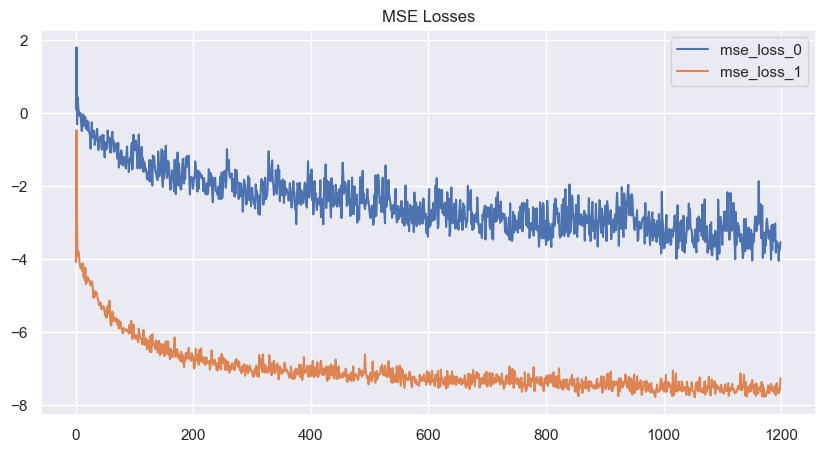

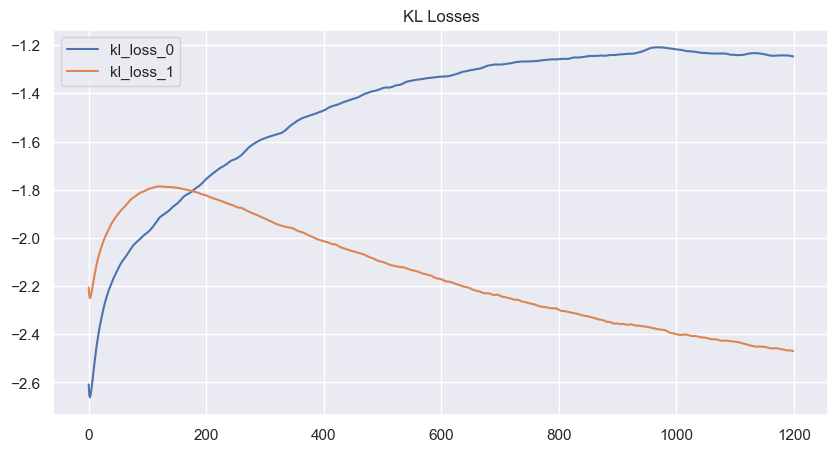

In [1298]:
print(mse_losses.shape)
print(kl_losses.shape)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10,5))
if len(mse_losses.shape) == 1:
    plt.plot(mse_losses, label = "mse_loss")
else:
    for i in range(mse_losses.shape[1]):
        plt.plot(mse_losses[:,i], label = "mse_loss_"+str(i))
plt.legend()
plt.title("MSE Losses")
plt.show()
plt.figure(figsize=(10,5))
if len(kl_losses.shape) == 1:
    plt.plot(kl_losses, label = "kl_loss")
else:
    for i in range(kl_losses.shape[1]):
        plt.plot(kl_losses[:,i], label = "kl_loss_"+str(i))
plt.legend()
plt.title("KL Losses")
plt.show()

- MSE : 0.487907, KL : 0.284778
- MSE : 0.523657, KL : 0.293330
- MSE : 0.522099, KL : 0.284558


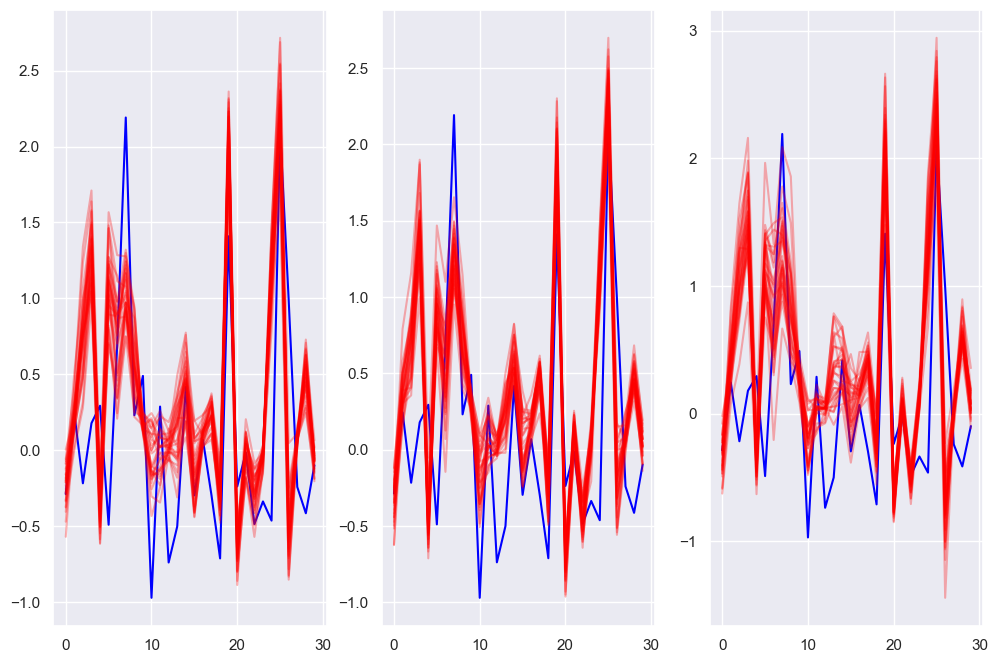

- MSE : 0.002546, KL : 0.081894
- MSE : 0.002436, KL : 0.085625
- MSE : 0.002619, KL : 0.086020


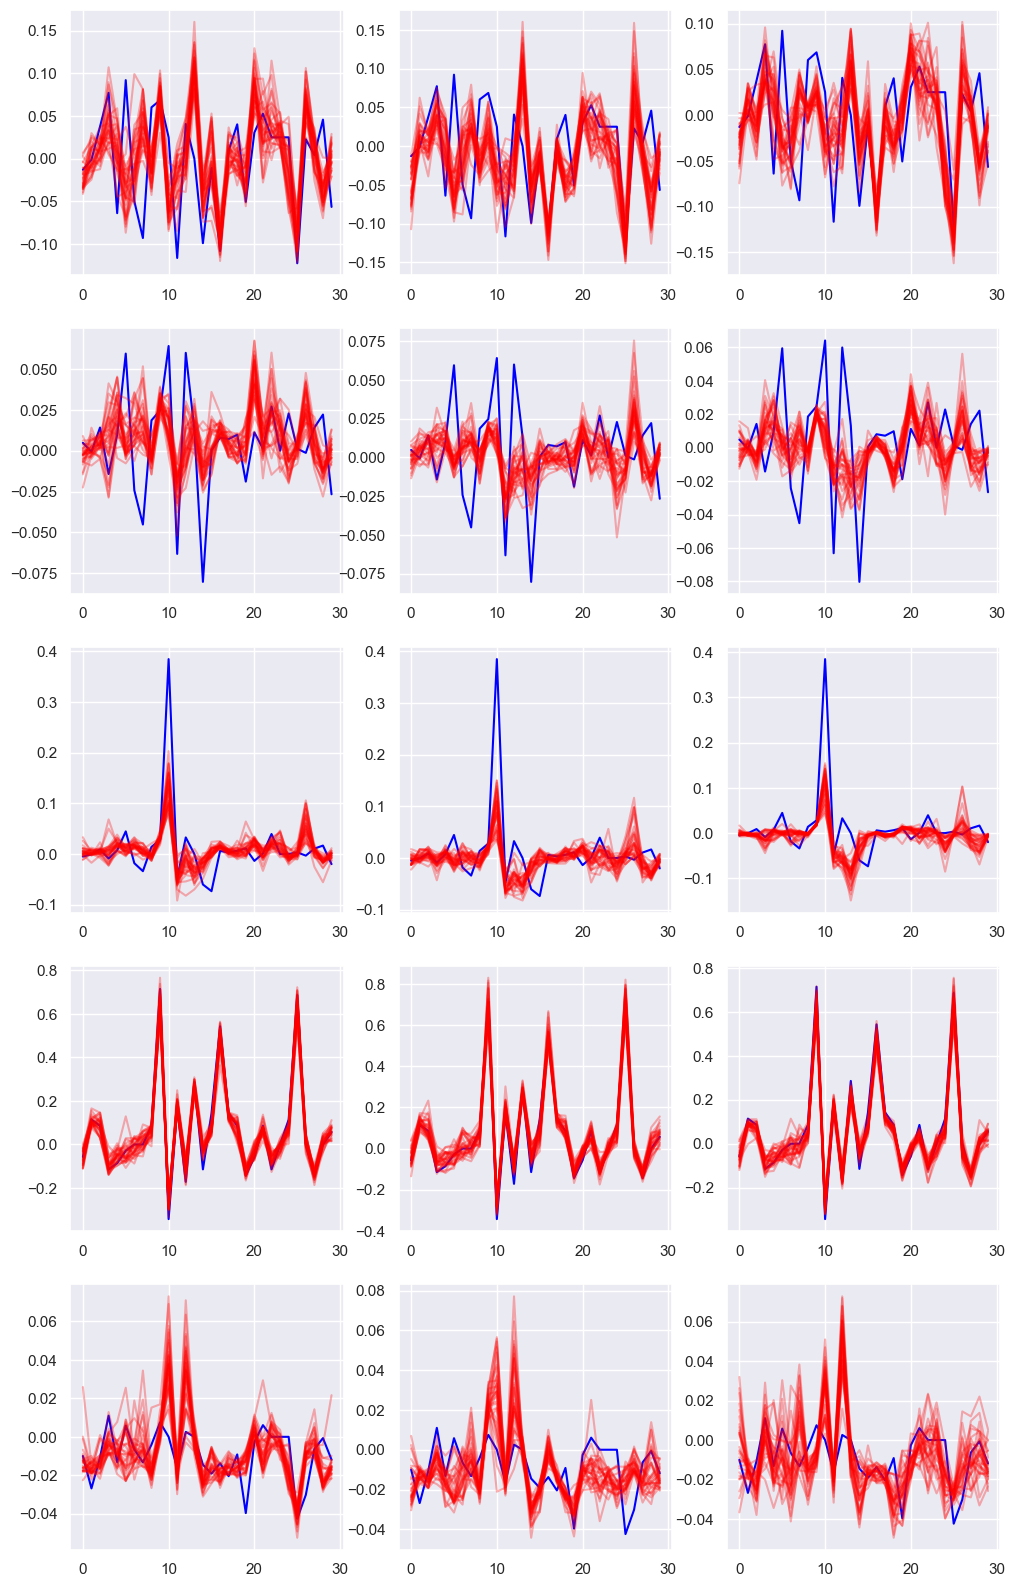

In [1299]:
# Run validation on test_inputs and test_outputs
model_keys = ["reward", "stochastic_multi"]
# model_key = "stochastic_multi"
# model_key = "reward"
# model_key = 8
plot_range =  30

# print(model_loss_optimizer_pool[model_key]["input_idxs"])
# print(model_loss_optimizer_pool[model_key]["target_idxs"])
for model_key in model_keys:
    mse_loss_fn = model_loss_optimizer_pool[model_key]["mse_loss"]
    kl_loss_fn = model_loss_optimizer_pool[model_key]["kl_loss"]
    test_inputs_filtered = test_inputs[:,model_loss_optimizer_pool[model_key]["input_idxs"]]
    test_outputs_filtered = test_outputs[:,model_loss_optimizer_pool[model_key]["target_idxs"]]
    # test_inputs.cpu().shape
    # grid creation:
    n_col = len(model_loss_optimizer_pool[model_key]["models"])
    n_row = test_outputs_filtered.shape[1]
    fig, axs = plt.subplots(n_row, n_col, figsize=(max(8,n_col*4),max(8,n_row*4)))
    for model_idx in range(len(model_loss_optimizer_pool[model_key]["models"])):
        pres = []
        for i in range(30):
            pre = model_loss_optimizer_pool[model_key]["models"][model_idx](test_inputs_filtered)
            pres.append(pre)
        mse = mse_loss_fn(pre, test_outputs_filtered)
        kl = kl_loss_fn(model_loss_optimizer_pool[model_key]["models"][model_idx])
        # # cost = mse + kl_weight*kl
        print('- MSE : %2.6f, KL : %2.6f' % (mse.item(), kl.item()))
        import matplotlib.pyplot as plt
        for i in range(test_outputs_filtered.shape[1]):
            if n_row == 1:
                if n_col == 1:
                    axs.plot(test_outputs_filtered[:plot_range,i].cpu().detach().numpy(), label='test_outputs', color = (0,0,1))
                    for j, pre in enumerate(pres):
                        axs.plot(pre[:plot_range,i].cpu().detach().numpy(), label='pre', color = (1,0,0,j/30), alpha = 0.3)
                else:
                    axs[model_idx].plot(test_outputs_filtered[:plot_range,i].cpu().detach().numpy(), label='test_outputs', color = (0,0,1))
                    for j, pre in enumerate(pres):
                        axs[model_idx].plot(pre[:plot_range,i].cpu().detach().numpy(), label='pre', color = (1,0,0,j/30), alpha = 0.3)
            else:
                if n_col == 1:
                    axs[i].plot(test_outputs_filtered[:plot_range,i].cpu().detach().numpy(), label='test_outputs', color = (0,0,1))
                    for j, pre in enumerate(pres):
                        axs[i].plot(pre[:plot_range,i].cpu().detach().numpy(), label='pre', color = (1,0,0,j/30), alpha = 0.3)
                else:
                    axs[i][model_idx].plot(test_outputs_filtered[:plot_range,i].cpu().detach().numpy(), label='test_outputs', color = (0,0,1))
                    for j, pre in enumerate(pres):
                        axs[i][model_idx].plot(pre[:plot_range,i].cpu().detach().numpy(), label='pre', color = (1,0,0,j/30), alpha = 0.3)
            # plt.legend()
    plt.show()

In [ ]:
# Run validation on test_inputs and test_outputs
model_key = 8
plot_range =  50
for model_idx in range(len(model_loss_optimizer_pool[model_key]["models"])):
    pres = []
    for i in range(30):
        pre = model_loss_optimizer_pool[model_key]["models"][model_idx](test_inputs)
        pres.append(pre)
    mse = mse_loss(pre, test_outputs[:,0])
    kl = kl_loss(model_loss_optimizer_pool[model_key]["models"][model_idx])
    # cost = mse + kl_weight*kl
    print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))
    value_idx = 0
    import matplotlib.pyplot as plt    
    plt.plot(test_outputs[:plot_range,0].cpu().detach().numpy(), label='test_outputs', color = (0,0,1))
    for i, pre in enumerate(pres):
        # Color the pre-lines in different red hues
        plt.plot(pre[:plot_range,value_idx].cpu().detach().numpy(), label='pre', color = (1,0,0,i/30), alpha = 0.3)
    plt.title(model_key)
    # plt.legend()
    plt.show()

In [ ]:
# plot test_outputs vs. pre in a human viewable way
# do this for the mean first 10 values in the second dimension of test_outputs and pre
import matplotlib.pyplot as plt
titles = ["rewards","N_level","P_level","K_level", "Week","Ground Type","DryWet","Humus","N_costs","P_costs","K_costs","Crop Price 1"]
for value_idx in range(12):
    plt.plot(test_outputs[:,value_idx].cpu().detach().numpy(), label='test_outputs')
    plt.plot(pre[:,value_idx].cpu().detach().numpy(), label='pre')
    plt.title(titles[value_idx])
    plt.legend()
    plt.show()
